In [90]:
import pandas as pd 
import string
from textblob import TextBlob
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
import collections
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


In [4]:
unused_columns = ['Unnamed: 0', 'id', 'time', 'tweet', 'language', 'hashtags', 'cashtags',
       'thumbnail', 'source', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest',
       'conversation_id', 'created_at', 'date', 'timezone', 'user_id',
       'username', 'name', 'place', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'link', 'retweet',
       'quote_url', 'video', 'near', 'geo', 'user_rt_id']
depressive_dataset = pd.read_csv('depressive_tweets_processed.csv')
#depressive_dataset.columns
depressive_dataset.drop(unused_columns, axis = 1, inplace = True)
depressive_dataset.head

/home/cristiansp/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,8,9,10,12,13,14,15,17,21,22,23,24,25,26,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<bound method NDFrame.head of                                               clean_tweet  vader_score  \
0       Yesterday I diagnosed depression. What's next ...      -0.3382   
1       Advice younger self : Depression doesnâ€™t go ...      -0.3400   
2                 @Lwhittenhart Hi Iâ€™m angry depression      -0.7906   
3       Need hair done bad . Iâ€™m hair depression ima...      -0.2732   
4       happiness contest depression contest receiving...       0.3400   
...                                                   ...          ...   
230699                                @bertanyarl suicide      -0.6705   
230700      @5thSu In spite trying suicide, fight Taliban      -0.8885   
230701  A coronial inquest heard Aboriginal man's huma...      -0.7096   
230702  I never life dreamed I kid. All poor addicted ...      -0.9100   
230703  #RunforLife2021 starts one month! Register tod...       0.0000   

        vader_sentiment_label  
0                           0  
1                

In [5]:
number_needed = 115352
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
random_dataset = pd.read_csv('random_dataset.csv', encoding='latin', names=columns)
#random_dataset = random_dataset.sample(frac=1)
positive_dataset = random_dataset[random_dataset['target'] == 4]
negative_dataset = random_dataset[random_dataset['target'] == 0]
print(positive_dataset.shape)
print(negative_dataset.shape)

(800000, 6)
(800000, 6)


In [6]:
positive_dataset = positive_dataset.sample(frac=1)
negative_dataset = negative_dataset.sample(frac=1)
positive_dataset = positive_dataset.iloc[0:number_needed, : ]
negative_dataset = negative_dataset.iloc[0:number_needed, : ]
print(positive_dataset.shape)
print(negative_dataset.shape)

(115352, 6)
(115352, 6)


In [7]:
random_dataset = pd.concat([positive_dataset, negative_dataset], ignore_index=True)
random_dataset.shape

(230704, 6)

In [87]:
random_dataset['target'].replace({4:1}, inplace=True)

In [88]:
random_dataset.head()

,target,ids,date,flag,user,text
0,1,2045001296,Fri Jun 05 10:05:45 PDT 2009,NO_QUERY,nokiko,#DotNetNuke #jQuery #jQueryUI drag and drop po...
1,1,1563598780,Sun Apr 19 23:27:52 PDT 2009,NO_QUERY,sajith,@aarthir I'm thinking of getting a Lenovo S10 ...
2,1,2068967512,Sun Jun 07 15:01:35 PDT 2009,NO_QUERY,sirijoy,"@Maestro cool, I'm waiting to here back from t..."
3,1,2004585534,Tue Jun 02 08:25:49 PDT 2009,NO_QUERY,Allecia13,"@arezzo2 I just saw ur msg, I hope u are able ..."
4,1,2014773005,Wed Jun 03 02:38:22 PDT 2009,NO_QUERY,sparve,@surfing_the_sun but to have the love for it i...


In [8]:
def clean_tweet(tweet):
    '''
    tweet -> is a single string 
    This method allows to remove some things in a tweet like the users, hashtags
    made by Cristian G. Sánchez Pineda based on: https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90,
    and: https://www.w3resource.com/python-exercises/re/python-re-exercise-42.php
    and: https://stackoverflow.com/questions/42370508/how-to-delete-special-characters-such-as-%C5%92%C3%B0%C5%B8-from-tweets
    '''
    #if len(demoji.findall(tweet))>0:
    #    tweet = demoji.replace(tweet, '')
    tweet = str(tweet)
    tweet = tweet.replace("'", '')
    tweet = tweet.replace("’",'')
    tweet = tweet.replace("…",'')
    tweet = ''.join([c for c in tweet if ord(c) < 128])
    tweet = re.sub(r'[0-9]', ' ', tweet) 
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    tweet = re.sub(r'[@#][^\s]+', ' ',tweet)
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    tweet = re.sub(r" +", ' ', tweet)
    tweet = remove_punctuation(tweet)
    tweet = remove_stop_words_tweet(tweet)
    return tweet

def remove_punctuation(tweet):
    '''
    tweet -> is a single string
    returns -> the string without punctuation
    Based on: https://stackoverrun.com/es/q/9452812
    '''
    tweet = re.sub('['+string.punctuation+']', '', tweet)
    return tweet

def remove_stop_words_tweet(tweet):
    '''
    tweet -> is a single string
    This method allows to remove the stopwords in english for a text
    made by Cristian G. Sánchez Pineda based on: "!#!"#!
    '''
    blob = TextBlob(tweet)
    stop_words = stopwords.words('english')
    items = blob.word_counts.items()
    textClean = [item for item in items if item[0] not in stop_words]
    listClean  = []
    for text in textClean:
        listClean.append(text[0]+" ")
    return "".join(listClean)

In [22]:
#all depressive words
depressive_tweets = depressive_dataset['clean_tweet'].values
depressive_clean_tweets = [clean_tweet(tweet) for tweet in depressive_tweets]

In [28]:
depressive_words = ''.join(depressive_clean_tweets).split(' ')
count_depressive_words = collections.Counter(depressive_words)
count_depressive_words.most_common(20)

[('depression', 95384),
 ('suicide', 48266),
 ('lonely', 40243),
 ('im', 24889),
 ('like', 20046),
 ('people', 13749),
 ('squad', 12544),
 ('get', 12145),
 ('one', 11619),
 ('anxiety', 11163),
 ('feel', 10556),
 ('know', 9885),
 ('time', 9756),
 ('dont', 8709),
 ('amp', 8652),
 ('life', 8148),
 ('really', 8029),
 ('think', 7729),
 ('even', 7020),
 ('good', 6941)]

In [29]:
depressive_clean_tweets = [t for t in depressive_clean_tweets if len(str(t)) > 6]
print(len(depressive_clean_tweets))

229150


In [79]:
def show_word_cloud(interestingWords):
    '''
    This method allows to create a word cloud using the
    made by Cristian G. Sánchez Pineda, based on: teacher Sonia's material  class
    '''
    stop = stopwords.words('english')  
    wordCloud = WordCloud(width=800, height=800, background_color='White', stopwords=stop, min_font_size=10).generate(interestingWords)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordCloud)
    plt.axis('on')
    plt.tight_layout(pad=0)
    plt.show()


In [44]:
count_depressive_words_df = pd.DataFrame(count_depressive_words.most_common(10),
                             columns=['words', 'count'])
count_depressive_words_df.head

<bound method NDFrame.head of         words  count
0  depression  95384
1     suicide  48266
2      lonely  40243
3          im  24889
4        like  20046
5      people  13749
6       squad  12544
7         get  12145
8         one  11619
9     anxiety  11163>

In [57]:
def show_bar_plot(dataframe, color, title):
    """
    based on: https://github.com/ram574/Detecting-Depression-in-Social-Media-via-Twitter-Usage/blob/main/02_data_cleaning.ipynb
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    dataframe.sort_values(by='count').plot(kind='barh', x='words', y='count', ax=ax, color=color, linestyle='-')

    ax.set_title(title)
    plt.grid(True)
    plt.show()

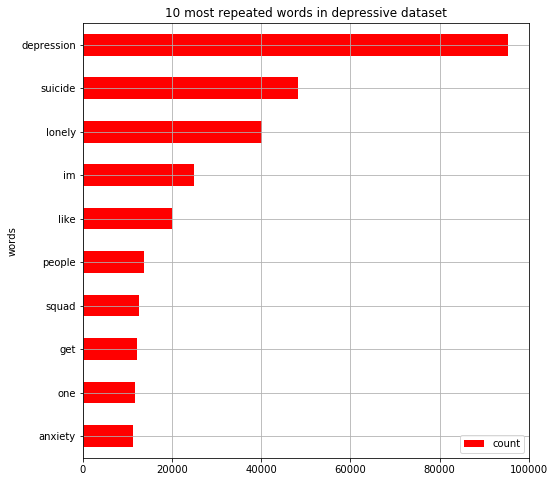

In [58]:
show_bar_plot(count_depressive_words_df, 'red', '10 most repeated words in depressive dataset')

In [72]:
def show_pie_chart(data, column, title):
    '''
    This method allows to create a pie chart with a particular design
    Made by: Cristian G. Sánchez Pineda, based on: https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
    '''
    sns.set_palette("Set1")
    labels = data[column].astype('category').cat.categories.tolist()
    counts = data[column].value_counts()
    sizes = [counts[value] for value in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)  # autopct is show the % on plot
    fig = plt.gcf()
    ax1.axis('equal') 
    plt.title(title) 
    plt.tight_layout()
    plt.show()

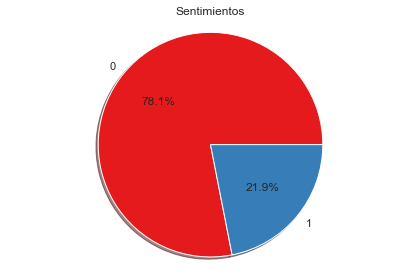

In [73]:
show_pie_chart(depressive_dataset, 'vader_sentiment_label', 'Sentimientos')

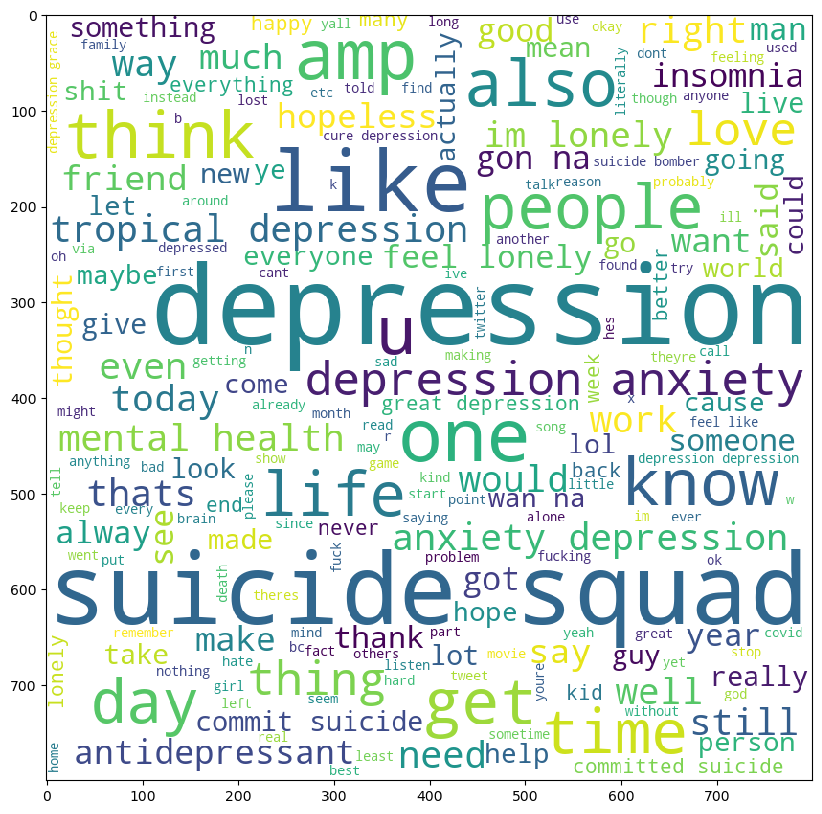

In [80]:
show_word_cloud(''.join(depressive_clean_tweets))

In [82]:
random_tweets = random_dataset['text'].values
random_clean_tweets = [clean_tweet(tweet) for tweet in random_tweets]

In [83]:
random_words = ''.join(random_clean_tweets).split(' ')
count_random_words = collections.Counter(random_words)
count_random_words.most_common(20)

[('im', 23789),
 ('good', 12298),
 ('day', 11654),
 ('get', 11321),
 ('like', 10803),
 ('go', 10020),
 ('got', 9692),
 ('dont', 9437),
 ('today', 8995),
 ('going', 8976),
 ('cant', 8826),
 ('work', 8687),
 ('love', 8660),
 ('time', 7859),
 ('back', 7821),
 ('lol', 7542),
 ('know', 7161),
 ('one', 7147),
 ('really', 6680),
 ('u', 6499)]

In [85]:
count_random_words_df = pd.DataFrame(count_random_words.most_common(10),
                             columns=['words', 'count'])
count_random_words_df.head

<bound method NDFrame.head of    words  count
0     im  23789
1   good  12298
2    day  11654
3    get  11321
4   like  10803
5     go  10020
6    got   9692
7   dont   9437
8  today   8995
9  going   8976>

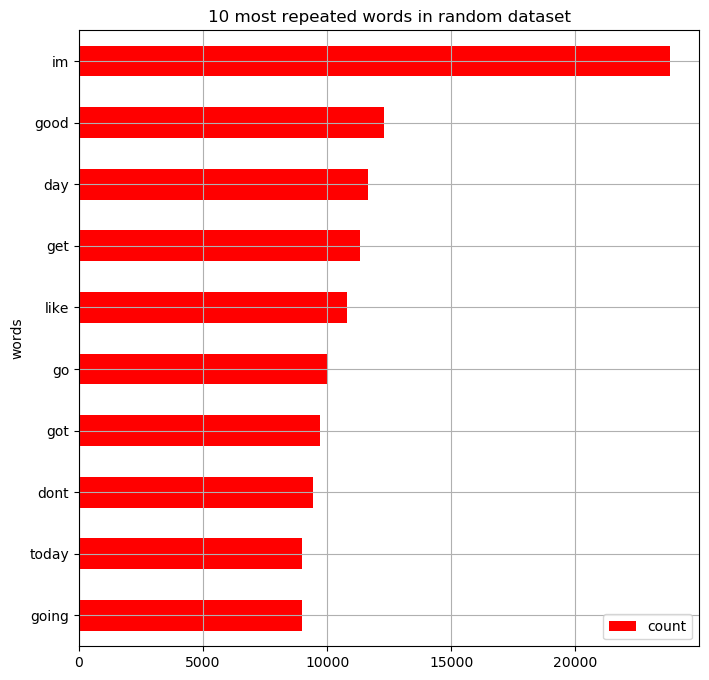

In [86]:
show_bar_plot(count_random_words_df, 'red', '10 most repeated words in random dataset')

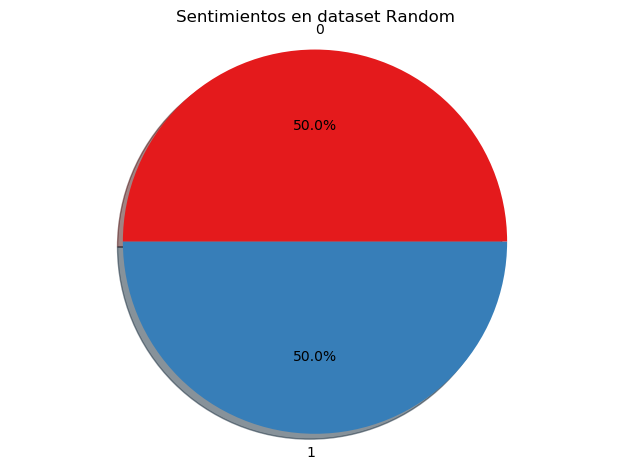

In [89]:
show_pie_chart(random_dataset, 'target', 'Sentimientos en dataset Random')

In [91]:
random_clean_tweets = [t for t in random_clean_tweets if len(str(t)) > 6]
print(len(random_clean_tweets))

226004


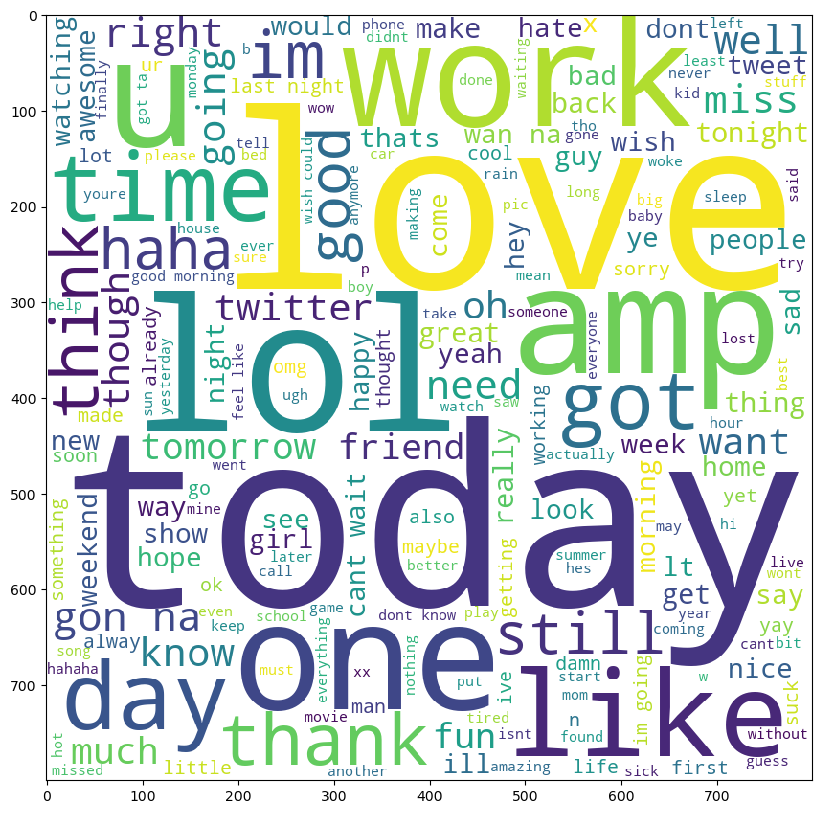

In [92]:
show_word_cloud(''.join(random_clean_tweets))

In [95]:
random_dataset_new = random_dataset.rename(columns={'target': 'sentiment_label', 'text':'tweet'})
random_dataset_new.drop(['ids', 'date', 'flag', 'user'], axis = 1, inplace = True)

random_dataset_new.head()


,sentiment_label,tweet
0,1,#DotNetNuke #jQuery #jQueryUI drag and drop po...
1,1,@aarthir I'm thinking of getting a Lenovo S10 ...
2,1,"@Maestro cool, I'm waiting to here back from t..."
3,1,"@arezzo2 I just saw ur msg, I hope u are able ..."
4,1,@surfing_the_sun but to have the love for it i...


In [96]:
depressive_dataset_new = depressive_dataset.rename(columns={'vader_sentiment_label': 'sentiment_label', 'clean_tweet':'tweet'})
depressive_dataset_new.drop(['vader_score'], axis = 1, inplace = True)

depressive_dataset_new.head()

,tweet,sentiment_label
0,Yesterday I diagnosed depression. What's next ...,0
1,Advice younger self : Depression doesnâ€™t go ...,0
2,@Lwhittenhart Hi Iâ€™m angry depression,0
3,Need hair done bad . Iâ€™m hair depression ima...,0
4,happiness contest depression contest receiving...,1


In [98]:
combined_dataset = pd.concat([depressive_dataset_new, random_dataset_new], ignore_index=True)
combined_dataset = combined_dataset.drop_duplicates()
combined_dataset.shape

(451494, 2)

In [99]:
export_csv = combined_dataset.to_csv(r'depressive_and_random_dataset.csv')
